In [5]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
from torchvision import transforms
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0
import torchvision.transforms as transforms

Separação de dados principais

In [6]:
df = pd.read_csv('classifications.csv')

In [ ]:
# Caminho para o diretório desejado
#!unzip 'imagens_segmentadas.zip'

In [7]:
caminho_diretorio ='imagem_segmentada/'

#Listar arquivos no diretório
arquivos = os.listdir(caminho_diretorio)

# Exibir os arquivos
print(arquivos)

['10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '2.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '3.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '4.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '5.png', '6.png', '7.png', '8.png', '9.png']


In [8]:
df['cell_id'] = df['cell_id'].astype(str)

# Mapeando os tipos de células para as imagens
ids_imagens = [os.path.splitext(imagem)[0] for imagem in arquivos]
df_filtrado = df[df['cell_id'].isin(ids_imagens)]

# Caminho completo para o diretório de imagens
caminho_completo = [os.path.join(caminho_diretorio, f"{id}.png") for id in ids_imagens]

# Carregar as imagens
imagens = [Image.open(caminho) for caminho in caminho_completo]

# Exemplo de redimensionamento e normalização
preprocessamento = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

imagens_processadas = [preprocessamento(imagem) for imagem in imagens]

# Divisão estratificada entre treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(
    imagens_processadas, df_filtrado['bethesda_system'],
    test_size=0.2, random_state=42, stratify=df_filtrado['bethesda_system']
)


Quantidade de imagens de treino: 36
Quantidade de imagens de teste: 10


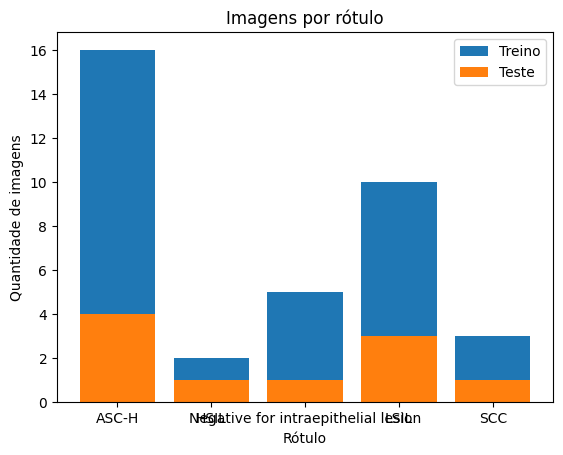

In [9]:
import collections
from matplotlib import pyplot

rotulos = df_filtrado['bethesda_system']

# Checando quantidade de imagens do dataset
print('Quantidade de imagens de treino:', len(x_treino))
print('Quantidade de imagens de teste:', len(x_teste))

# Contando quantidade de imagens por rótulo
counterTreino = collections.Counter(y_treino)
counterTeste = collections.Counter(y_teste)

# Plotando quantidade de imagens de cada rótulo
fig, ax = pyplot.subplots()
rects1 = ax.bar(counterTreino.keys(), counterTreino.values(), label='Treino')
rects2 = ax.bar(counterTeste.keys(), counterTeste.values(), label='Teste')

ax.set_title('Imagens por rótulo')
ax.set_ylabel('Quantidade de imagens')
ax.set_xlabel('Rótulo')
ax.legend()
pyplot.show()

# Classificação de Mahalnobis

Distância de Mahalanobis:  [363.09270687  47.95087199   7.71087389 184.50334742  59.70497553
  62.15281094  26.50480181 108.83440928  42.8987337   31.3900867 ]
Acurácia:  0.1
Matriz de Confusão:
[[1 0]
 [9 0]]


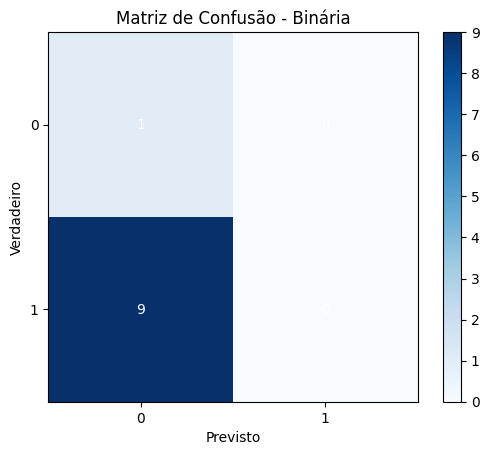

In [22]:
# Converter para numpy arrays
x_treino_np = np.array([img.numpy().flatten() for img in x_treino])
x_teste_np = np.array([img.numpy().flatten() for img in x_teste])

# Mapeamento de classes
class_mapping = {'Negative for intraepithelial lesion': 0}

# Atribuir rótulo 1 para todas as outras classes
for label in df_filtrado['bethesda_system'].unique():
    if label not in class_mapping:
        class_mapping[label] = 1

# Mapeamento dos rótulos verdadeiros
y_true_int = np.array([class_mapping[label] for label in y_teste])

# Aplicar PCA para reduzir a dimensionalidade
n_components = min(x_treino_np.shape[0], x_treino_np.shape[1])
pca = PCA(n_components=n_components)
x_treino_pca = pca.fit_transform(x_treino_np)
x_teste_pca = pca.transform(x_teste_np)

# Calcular a matriz de covariância e seu inverso para o conjunto de treino reduzido
cov_matrix = np.cov(x_treino_pca, rowvar=False)
regularization_term = 1e-5
cov_matrix_regularized = cov_matrix + regularization_term * np.eye(cov_matrix.shape[0])
inv_cov_matrix = np.linalg.inv(cov_matrix_regularized)

# Calcular a distância Mahalanobis
mahalanobis_dist = [distance.mahalanobis(imagem, np.mean(x_treino_pca, axis=0), inv_cov_matrix) for imagem in x_teste_pca]
mahalanobis_dist_array = np.array(mahalanobis_dist)

# Ajustar o limiar conforme necessário
limiar = 5.0

# Criar rótulos previstos com base nas distâncias
y_pred_int = [0 if dist > limiar else 1 for dist in mahalanobis_dist_array]

# Calcular a acurácia usando y_true_int e y_pred_int
acc_binary = accuracy_score(y_true_int, y_pred_int)

# Calcular a matriz de confusão
cm_binary = confusion_matrix(y_true_int, y_pred_int)

# Exibir resultados
print("Distância de Mahalanobis: ", mahalanobis_dist_array)
print("Acurácia: ", acc_binary)
print("Matriz de Confusão:")
print(cm_binary)

# Plotar a matriz de confusão
plt.imshow(cm_binary, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Binária')
plt.colorbar()

# Adicionar anotações
for i in range(cm_binary.shape[0]):
    for j in range(cm_binary.shape[1]):
        plt.text(j, i, str(cm_binary[i, j]), ha='center', va='center', color='white')

# Adicionar rótulos
classes = np.unique(y_true_int)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

Distâncias de Mahalanobis:  [363.09270687  47.95087199   7.71087389 184.50334742  59.70497553
  62.15281094  26.50480181 108.83440928  42.8987337   31.3900867 ]
Acurácia:  0.1
Matriz de Confusão:
[[0 1 0 0 0]
 [0 1 0 0 0]
 [0 3 0 0 0]
 [0 1 0 0 0]
 [0 4 0 0 0]]


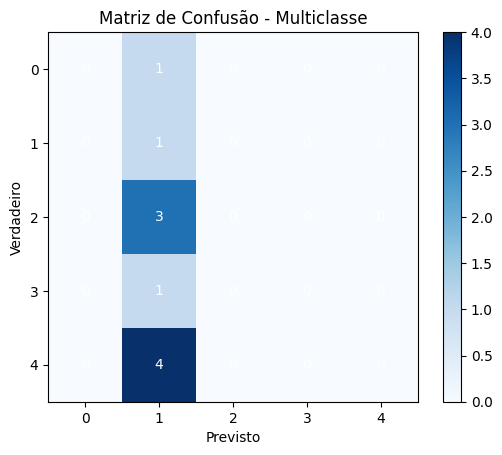

In [27]:
x_treino_np = np.array([img.numpy().flatten() for img in x_treino])
x_teste_np = np.array([img.numpy().flatten() for img in x_teste])

n_components = min(x_treino_np.shape[0], x_treino_np.shape[1])
pca = PCA(n_components=n_components)
x_treino_pca = pca.fit_transform(x_treino_np)
x_teste_pca = pca.transform(x_teste_np)

class_mapping = {label: idx for idx, label in enumerate(df_filtrado['bethesda_system'].unique())}


# Calcular a matriz de covariância e seu inverso para o conjunto de treino reduzido
cov_matrix = np.cov(x_treino_pca, rowvar=False)
regularization_term = 1e-5
cov_matrix_regularized = cov_matrix + regularization_term * np.eye(cov_matrix.shape[0])
inv_cov_matrix = np.linalg.inv(cov_matrix_regularized)

# Calcular a distância Mahalanobis
mahalanobis_dist = [distance.mahalanobis(imagem, np.mean(x_treino_pca, axis=0), inv_cov_matrix) for imagem in x_teste_pca]
mahalanobis_dist_array = np.array(mahalanobis_dist)

# Ajustar o limiar conforme necessário
limiar = 5.0

y_true_int = np.array([class_mapping[label] for label in y_teste])

# Criar rótulos previstos com base nas distâncias
y_pred_int = (mahalanobis_dist_array > limiar).astype(int)

# Ajustar a forma de y_true_int
y_true_int = y_true_int.ravel()

# Ajustar a forma de y_pred_int
y_pred_int = y_pred_int.ravel()

# Garantir que y_true_int e y_pred_int tenham o mesmo número de amostras
min_samples = min(len(y_true_int), len(y_pred_int))
y_true_int = y_true_int[:min_samples]
y_pred_int = y_pred_int[:min_samples]

# Calcular a acurácia usando y_true_int e y_pred_int
acc_multiclass = accuracy_score(y_true_int, y_pred_int)

# Calcular a matriz de confusão
cm_multiclass = confusion_matrix(y_true_int, y_pred_int)

# Exibir resultados
print("Distâncias de Mahalanobis: ", mahalanobis_dist_array)
print("Acurácia: ", acc_multiclass)
print("Matriz de Confusão:")
print(cm_multiclass)

# Plotar a matriz de confusão
plt.imshow(cm_multiclass, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Multiclasse')
plt.colorbar()

# Adicionar anotações
for i in range(cm_multiclass.shape[0]):
    for j in range(cm_multiclass.shape[1]):
        plt.text(j, i, str(cm_multiclass[i, j]), ha='center', va='center', color='white')

# Adicionar rótulos
classes = np.unique(y_true_int)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

# Classificação CNN

In [10]:
class EfficientNetBinary(nn.Module):
    def __init__(self):
        super(EfficientNetBinary, self).__init__()
        self.model = efficientnet_b0(pretrained=True)
        self.model.classifier[1] = nn.Linear(1280, 2)

    def forward(self, x):
        return self.model(x)


class EfficientNetMulti(nn.Module):
    def __init__(self):
        super(EfficientNetMulti, self).__init__()
        self.model = torchvision.models.efficientnet_b0(pretrained=True)
        self.model.classifier[1] = nn.Linear(1280, 6)

    def forward(self, x):
        return self.model(x)

In [11]:
class CustomDataset_Binario(Dataset):
    def __init__(self, caminho_diretorio, df_filtrado, images, labels, transform=None):
        self.caminho_diretorio = caminho_diretorio
        self.df_filtrado = df_filtrado
        self.images = images
        self.labels = labels
        self.transform = transform
        self.class_mapping = {'Negative for intraepithelial lesion': 0}

        # Atribuir rótulo 1 para todas as outras classes
        for label in df_filtrado['bethesda_system'].unique():
            if label not in self.class_mapping:
                self.class_mapping[label] = 1

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.df_filtrado.iloc[idx]['cell_id']
        img_path = os.path.join(self.caminho_diretorio, f"{img_name}.png")

        if not os.path.exists(img_path):
            print(f"Arquivo não encontrado: {img_path}")
            return torch.zeros(3, 64, 64), torch.tensor(-1, dtype=torch.long)

        # Carregar a imagem
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = self.df_filtrado.iloc[idx]['bethesda_system']
        label_tensor = torch.tensor(self.class_mapping[label], dtype=torch.long)

        return image, label_tensor


In [19]:
# Criar o DataLoader para treinamento
train_dataset = CustomDataset_Binario(caminho_diretorio, df_filtrado, x_treino, y_treino, transform=preprocessamento)
train_loader = DataLoader(train_dataset, batch_size=36, shuffle=True)

# Criar o DataLoader para teste
test_dataset = CustomDataset_Binario(caminho_diretorio, df_filtrado, x_teste, y_teste, transform=preprocessamento)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Instanciar o modelo
efficientnet_binary = EfficientNetBinary()

# Definir critério e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_binary.parameters(), lr=0.0001)

# Treinar o modelo
for epoch in range(100):
    # Modo de treinamento
    efficientnet_binary.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader):
        inputs, train_labels = data

        optimizer.zero_grad()
        outputs = efficientnet_binary(inputs)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()


    # Avaliar no conjunto de teste
    efficientnet_binary.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for i, data in enumerate(test_loader):
            inputs, test_labels = data
            outputs = efficientnet_binary(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()

        accuracy = 100 * correct / total

# Acurácia de treino
efficientnet_binary.train()
correct = 0
total = 0

for i, data in enumerate(train_loader):
    inputs, labels = data
    outputs = efficientnet_binary(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy_train = 100 * correct / total

# Acurácia de teste
efficientnet_binary.eval()
all_true_labels = []
all_predicted_labels = []
correct = 0
total = 0

for i, data in enumerate(test_loader):
    inputs, labels = data
    outputs = efficientnet_binary(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy_test = 100 * correct / total

print(f"Acurácia de treino: {accuracy_train:.2f}%")
print(f"Acurácia de teste: {accuracy_test:.2f}%")

C:\Users\Home\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Home\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Acurácia de treino: 100.00%
Acurácia de teste: 100.00%


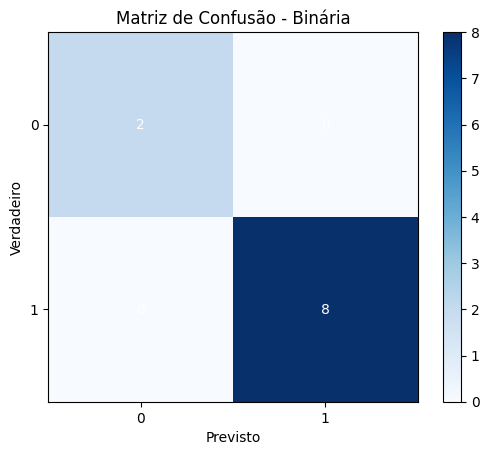

In [21]:
all_true_labels.extend(test_labels.cpu().numpy())  # Convertendo para NumPy
all_predicted_labels.extend(predicted.cpu().numpy())  # Convertendo para NumPy

cm_binary = confusion_matrix(all_true_labels, all_predicted_labels)

# Plotar a matriz de confusão
plt.imshow(cm_binary, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Binária')
plt.colorbar()

# Adicionar anotações
for i in range(cm_binary.shape[0]):
    for j in range(cm_binary.shape[1]):
        plt.text(j, i, str(cm_binary[i, j]), ha='center', va='center', color='white')

# Adicionar rótulos
classes = np.unique(all_true_labels)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

In [16]:
class CustomDataset_Multiclasse(Dataset):
    def __init__(self, caminho_diretorio, df_filtrado, images, labels, transform=None):
        self.caminho_diretorio = caminho_diretorio
        self.df_filtrado = df_filtrado
        self.images = images
        self.labels = labels
        self.transform = transform
        self.class_mapping = {label: idx for idx, label in enumerate(df_filtrado['bethesda_system'].unique())}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.df_filtrado.iloc[idx]['cell_id']
        img_path = os.path.join(self.caminho_diretorio, f"{img_name}.png")

        if not os.path.exists(img_path):
            print(f"Arquivo não encontrado: {img_path}")
            return torch.zeros(3, 64, 64), torch.tensor(-1, dtype=torch.long)

        # Carregar a imagem
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = self.df_filtrado.iloc[idx]['bethesda_system']
        label_tensor = torch.tensor(self.class_mapping[label], dtype=torch.long)

        return image, label_tensor

In [22]:
# Criar o DataLoader para treinamento
train_dataset = CustomDataset_Multiclasse(caminho_diretorio, df_filtrado, x_treino, y_treino, transform=preprocessamento)
train_loader = DataLoader(train_dataset, batch_size=36, shuffle=True)

# Criar o DataLoader para teste
test_dataset = CustomDataset_Multiclasse(caminho_diretorio, df_filtrado, x_teste, y_teste, transform=preprocessamento)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Instanciar o modelo
efficientnet_multi = EfficientNetMulti()

# Definir critério e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_multi.parameters(), lr=0.0001)

# Treinar o modelo
for epoch in range(100):
    # Modo de treinamento
    efficientnet_multi.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader):
        inputs, train_labels = data

        optimizer.zero_grad()
        outputs = efficientnet_multi(inputs)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()


    # Avaliar no conjunto de teste
    efficientnet_multi.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for i, data in enumerate(test_loader):
            inputs, test_labels = data
            outputs = efficientnet_multi(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()

        accuracy = 100 * correct / total

# Acurácia de treino
efficientnet_multi.train()
correct = 0
total = 0

for i, data in enumerate(train_loader):
    inputs, labels = data
    outputs = efficientnet_multi(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy_train = 100 * correct / total

# Acurácia de teste
efficientnet_multi.eval()
all_true_labels = []
all_predicted_labels = []
correct = 0
total = 0

for i, data in enumerate(test_loader):
    inputs, labels = data
    outputs = efficientnet_multi(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy_test = 100 * correct / total

print(f"Acurácia de treino: {accuracy_train:.2f}%")
print(f"Acurácia de teste: {accuracy_test:.2f}%")


C:\Users\Home\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Home\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Acurácia de treino: 100.00%
Acurácia de teste: 100.00%


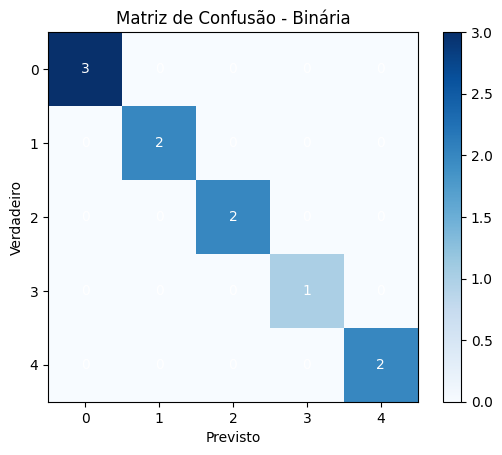

In [23]:
all_true_labels.extend(test_labels.cpu().numpy())  # Convertendo para NumPy
all_predicted_labels.extend(predicted.cpu().numpy())  # Convertendo para NumPy

cm_multi= confusion_matrix(all_true_labels, all_predicted_labels)

# Plotar a matriz de confusão
plt.imshow(cm_multi, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - MultiClasse')
plt.colorbar()

# Adicionar anotações
for i in range(cm_multi.shape[0]):
    for j in range(cm_multi.shape[1]):
        plt.text(j, i, str(cm_multi[i, j]), ha='center', va='center', color='white')

# Adicionar rótulos
classes = np.unique(all_true_labels)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()